In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:31<00:00,  1.67it/s]


In [3]:
from torch.utils.data import DataLoader, Subset

def customRandomSplit(dataset, train_size, val_size, test_size):
    # TODO: DONT think its adding in the indices +1 and +2 need to add that to all the indices arrays
    rnd_Seed=42
    mandatory_test_models = ["88d183f319cddb7344221bef0fa3c36b","ce40b134b11e8c822bbc2c380e91dfe2","67bc9bec05f78850f9e08161aea27d2f","ba494b33be3a3e0dc1bbb501b1d87871","15cc3d9020384e8d6e09a8e31c7575c5","bc6a3fa659dd7ec0c62ac18334863d36","46dbba829a57ace8cffd61677456447e","1d527bbed4d12817fa3bb91f4e3cd35f","f400eb5421283e8a102f4912aece242b","899af991203577f019790c8746d79a6f"]
    data_len = len(dataset)
    train_size = int(round((train_size * data_len)/3))
    val_size   = int(round((val_size * data_len)/3))
    test_size  = int(round((test_size * data_len)/3))

    assert train_size*3 + val_size*3 + test_size*3 == data_len, "The split sizes do not add up to the dataset size"
    # Using pytorch subsets to split the dataset
    # 3 is the number of frames per model
    # randomly sample indices for the train size
    choices = np.arange(0, data_len, 3, dtype=int)
    # get the index numbers for the mandatory test models from dataset dataframe
    mandatory_test_indices = []
    for i in range(len(mandatory_test_models)):
        mandatory_test_indices.append(dataset.dataframe[dataset.dataframe["model_id"] == mandatory_test_models[i]].index[0])
    mandatory_test_indices = np.array(np.array(mandatory_test_indices), dtype=int)
    # remove the values in mandatory_test_indices from the choices
    choices = np.setdiff1d(choices, mandatory_test_indices)
    
    np.random.seed(rnd_Seed)
    np.random.shuffle(choices)
    # randomly sample indices for the train size
    train_indices = choices[:train_size]
    # randomly sample indices for the val size
    val_indices = choices[train_size:train_size+val_size]
    # randomly sample indices for the test size
    test_indices = choices[train_size+val_size:train_size+val_size+test_size]
    # add the mandatory test indices to the test indices
    test_indices = np.concatenate((test_indices, mandatory_test_indices))
    # final check the values in mandatory_test_indices are in test_indices
    assert np.all(np.isin(mandatory_test_indices, test_indices)), "The mandatory test indices are not in the test indices"
    # check mandatory_test_indices values arent in the other 2
    assert np.all(np.isin(mandatory_test_indices, train_indices)) == False, "The mandatory test indices are in the train indices"
    assert np.all(np.isin(mandatory_test_indices, val_indices)) == False, "The mandatory test indices are in the val indices"


    train_indices = np.concatenate((train_indices, train_indices+1, train_indices+2))
    val_indices = np.concatenate((val_indices, val_indices+1, val_indices+2))
    test_indices = np.concatenate((test_indices, test_indices+1, test_indices+2))
    # no intersections between the sets
    it = np.intersect1d(train_indices, val_indices)
    it2 = np.intersect1d(train_indices, test_indices)
    it3 = np.intersect1d(val_indices, test_indices)
    assert len(it) == 0 , f"The train and val sets have the same indices {it}"
    assert len(it2) == 0 , f"The train and test sets have the same indices {it2}"
    assert len(it3) == 0 , f"The val and test sets have the same indices{it3}"
    
    # create the subsets
    train_set = Subset(dataset, train_indices)
    val_set   = Subset(dataset, val_indices,)
    test_set  = Subset(dataset, test_indices)
    assert len(train_set) + len(val_set) + len(test_set) == data_len, "The split sizes do not add up to the dataset size"
    return train_set, val_set, test_set

In [4]:
train_split = 0.7
valid_split = 0.1
test_split = 0.2

augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

train_dataset, valid_dataset, test_dataset = customRandomSplit(thickness_dataset, train_split, valid_split, test_split)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=128)
print("# of samples in test set:", len(test_dataset))

# of samples in test set: 1311


In [5]:
# 85 and 107 148are also intersting epochs
# path = f"models\Full train (balanced)\model_20230329-155809_148" 
# path = "models\Full train (balanced)\model_20230329-155809_85"
path = "models\Full train (balanced)\model_20230329-155809_107" # best model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = U_Net()

criterion = nn.MSELoss()
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()
trained_model = model

Using cuda device


In [6]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans ,mse_loss_with_nans_with_extras
from torchmetrics import PeakSignalNoiseRatio
full_loss = 0
fullstrsim = 0
full_mape = 0
batches = 0
catagory_losses = {}
catagory_index = {} # appends tuple to list that stores as batch_no, idx in batch
mean_abs_percentage_error = PeakSignalNoiseRatio().to(device)

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        catagory_id = data['catagory_id']
        outputs = trained_model(images)
        
        masked_loss, losses = mse_loss_with_nans_with_extras(outputs, labels)

        # using the catagory id to keep adding the loss to the scores
        for i in range(losses.shape[0]):
            if catagory_id[i] in catagory_losses:
                catagory_losses[catagory_id[i]].append(losses[i].cpu().numpy())
                catagory_index[catagory_id[i]].append((batches, i))
                
            else:
                catagory_losses[catagory_id[i]] = [losses[i].cpu().numpy()]
                catagory_index[catagory_id[i]] = [(batches, i)]


        mape = mean_abs_percentage_error(outputs, labels)
        strsim = 0 
        for i in range(labels.cpu().numpy().shape[0]):
            strsim += ssim(outputs[i].cpu().numpy()[0], labels[i].cpu().numpy()[0])

        fullstrsim += strsim/labels.cpu().numpy().shape[0]
        full_mape += mape
        full_loss += masked_loss
        batches += 1
print("Test SSIM: {}".format(fullstrsim/batches))
print("Test loss: {}".format(full_loss/batches))
print("Test MAPE: {}".format(full_mape/batches))

Test SSIM: 0.9692839893986002
Test loss: 0.0007299802964553237
Test MAPE: 29.51276206970215


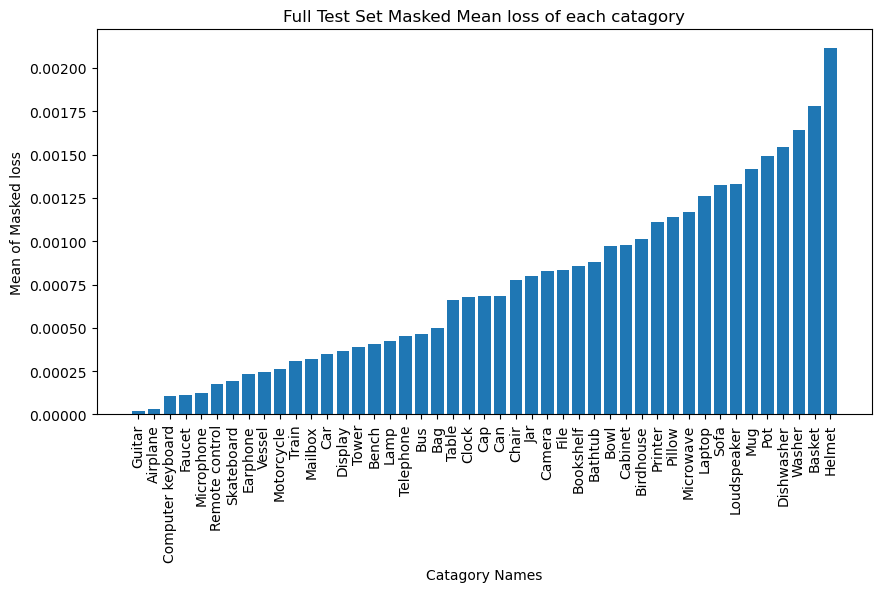

In [7]:
# for each catagory calculate the mean then plot a bar graph of the mean loss of each catagory
catagory_mean_losses = {}
for catagory in catagory_losses:
    catagory_mean_losses[catagory] = np.mean(catagory_losses[catagory])
catagory_lens = {}
for catagory in catagory_losses:
    catagory_lens[catagory] = len(catagory_losses[catagory])



# catagory_mean_losses sorted by the mean loss
catagory_mean_losses = {k: v for k, v in sorted(catagory_mean_losses.items(), key=lambda item: item[1])}

fig = plt.figure(figsize=(10, 5))
plt.title("Full Test Set Masked Mean loss of each catagory")
plt.xlabel("Catagory Names")
plt.ylabel("Mean of Masked loss")
    # change the xticks rotate the labels 90 degrees
plt.bar(catagory_mean_losses.keys(), catagory_mean_losses.values())
plt.xticks(rotation=90)
# using thickness_dataset.labels to get the catagory name strings for the xticks
plt.xticks(list(catagory_mean_losses.keys()), [thickness_dataset.labels[i].split(',')[0].capitalize() for i in catagory_mean_losses.keys()])


plt.show()
# save as pdf
fig.savefig("figs\\full\\mean_loss_of_each_catagory.pdf", bbox_inches='tight')


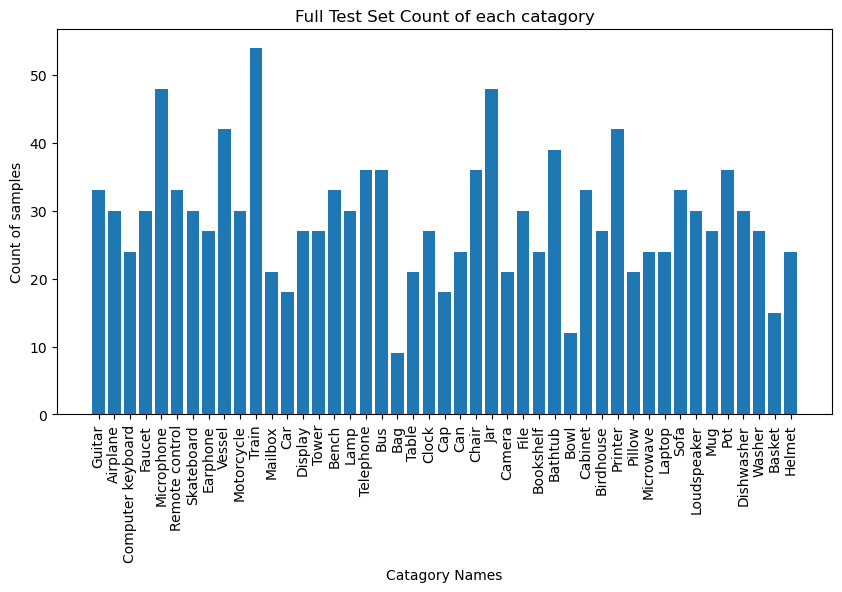

In [8]:
# plot count of each catgory, sorted by the acending mean loss dict
# catagory_lens sorted by the mean loss dictionary catagory_mean_losses

catagory_lens = {k: v for k, v in sorted(catagory_lens.items(), key=lambda item: catagory_mean_losses[item[0]])}

fig = plt.figure(figsize=(10, 5))
plt.title("Full Test Set Count of each catagory")
plt.xlabel("Catagory Names")
plt.ylabel("Count of samples")

plt.bar(catagory_lens.keys(), catagory_lens.values())
plt.xticks(rotation=90)
# using thickness_dataset.labels to get the catagory name strings for the xticks
plt.xticks(list(catagory_lens.keys()), [thickness_dataset.labels[i].split(',')[0].capitalize() for i in catagory_lens.keys()])
plt.show()
# save as pdf
fig.savefig("figs\\full\\count_of_each_catagory.pdf", bbox_inches='tight')


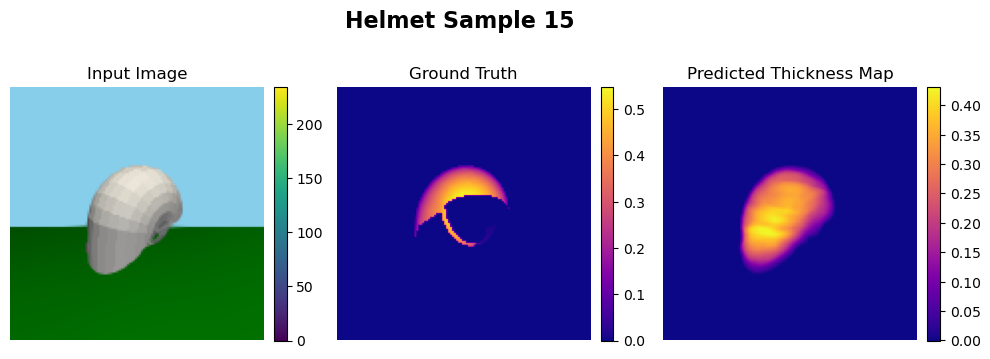

Structure Simililarity:  0.9003183405193914


In [118]:
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
id = "03513137"
num = 15
# locator 
batch_no, sample_no =catagory_index[id][num]
iters = 0
with torch.no_grad():
    for data in test_dataloader:
        samples = data
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        image_locs = data['img_loc']
        outputs = trained_model(images)
        if iters == batch_no:
            for i in range(outputs.shape[0]):
                if i == sample_no:
                    img_loc = image_locs[i]

                    fig = plt.figure(figsize=(12,8))
                    grid = ImageGrid(fig, 111,
                                     nrows_ncols = (1,3),
                                     axes_pad = .5,
                                     cbar_location = "right",
                                     cbar_mode="each",
                                     cbar_size="5%",
                                     cbar_pad=0.1,
                                    )

                    im1 = grid[0].imshow(cv2.cvtColor(cv2.imread(img_loc), cv2.COLOR_BGR2RGB), aspect="equal")
                    grid[0].set_title('Input Image')
                    grid[0].axis('off')
                    grid.cbar_axes[0].colorbar(im1)
                    grid.cbar_axes[0].toggle_label(True)
                    im2 = grid[1].imshow(labels[i].cpu().numpy()[0], cmap='plasma')
                    grid[1].set_title('Ground Truth')
                    grid[1].axis('off')
                    grid.cbar_axes[1].colorbar(im2)
                    im3= grid[2].imshow(outputs[i].cpu().numpy()[0], cmap='plasma')
                    grid[2].set_title('Predicted Thickness Map')
                    grid[2].axis('off')
                    grid.cbar_axes[2].colorbar(im3)
                    fig.suptitle(f"{thickness_dataset.labels[id].split(',')[0].capitalize()} Sample {num}", fontsize=16,y=0.75, fontweight = "600")
                    plt.show()
                    fig.savefig("figs\\full\\sample_{}_from_catagory_{}.pdf".format(num, data['catagory_id'][i]), bbox_inches='tight')
                    print("Structure Simililarity: ",ssim(labels[i].cpu().numpy()[0], outputs[i].cpu().numpy()[0].reshape(128,128)))
                    break
            break
        iters +=1